In [57]:
# this is our preamble cell :
import plotly.graph_objects as go
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib 


import category_encoders as ce
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

from sklearn import cluster
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [58]:
# OK, importing and minor cleaning first. 

dfreal = pd.read_csv('True.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')
dfreal['Fake'] = 0
print('Real data shape: ', dfreal.shape)

dffake = pd.read_csv('Fake.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')

dffake['Fake'] = 1

# I have added the boolean column for Fake/Real to each. 

# This next bit will clean up the messy date columns from the fake csv. 

searchfor = ['http', '-', 'MSNBC']
dffake = dffake[~dffake['date'].str.contains('|'.join(searchfor))]

print('Fake data shape: ', dffake.shape)

Real data shape:  (21417, 5)
Fake data shape:  (23436, 5)


In [59]:
# Now, I want to trim them to be the same size, so that we have our baseline right at 0.5 -the same as flipping a coin. 

dfreal_trimmed = dfreal[-21_400 :]
print('Real trimmed shape: ', dfreal_trimmed.shape)

dffake_trimmed = dffake[-21_400 :]
print('Fake trimmed shape: ', dffake_trimmed.shape)

# and now combine them into one dataframe:
df_joined = dfreal_trimmed.append(dffake_trimmed, ignore_index=True)

df_joined['date'] = pd.to_datetime(df_joined['date'])

print()
print('Combined and trimmed (equal parts Real and Fake) shape: ', df_joined.shape)
print()
#print(df_joined.info)

Real trimmed shape:  (21400, 5)
Fake trimmed shape:  (21400, 5)

Combined and trimmed (equal parts Real and Fake) shape:  (42800, 5)



In [60]:
# we're going to need to drop those colums that will interfere with the model once we have vectorized the text. 
# for now, we will drop subject and leave date. 

df_joined.drop(['subject'], axis=1, inplace=True)
print(df_joined.shape)

(42800, 4)


## Now I'm going to print the text, date and fake boolean into a new dataframe...
we might play with this later if we have time, could be fun to see whether or not title returns similar results to text...

In [61]:
print(df_joined.columns)

Index(['title', 'text', 'date', 'Fake'], dtype='object')


In [78]:

df_joined_titles = df_joined.drop(['text'], axis=1)
df_joined = df_joined.drop(['title'], axis=1)
print(df_joined_titles.shape)
print()
print(df_joined_titles.info)

(42800, 3)

<bound method DataFrame.info of                                                    title       date  Fake
0      Trump on Twitter (Dec 26) - Hillary Clinton, T... 2017-12-26     0
1      U.S. appeals court rejects challenge to Trump ... 2017-12-26     0
2      Treasury Secretary Mnuchin was sent gift-wrapp... 2017-12-24     0
3      Federal judge partially lifts Trump's latest r... 2017-12-24     0
4      Exclusive: U.S. memo weakens guidelines for pr... 2017-12-23     0
...                                                  ...        ...   ...
42795  McPain: John McCain Furious That Iran Treated ... 2016-01-16     1
42796  JUSTICE? Yahoo Settles E-mail Privacy Class-ac... 2016-01-16     1
42797  Sunnistan: US and Allied ‘Safe Zone’ Plan to T... 2016-01-15     1
42798  How to Blow $700 Million: Al Jazeera America F... 2016-01-14     1
42799  10 U.S. Navy Sailors Held by Iranian Military ... 2016-01-12     1

[42800 rows x 3 columns]>


In [79]:
# Now that we've got a seperate frame we can drop title from df_joined, and we can print our baseline. 
#
# COMMENTED OUT BECAUSE WE RAN THE CELL ALREADY
# df_joined = df_joined.drop(['title'], axis=1)
print('df_joined - the one with the text: ',df_joined.shape)
print(df_joined.columns)
print()
print()
print('df_joined_titles - the one with the titles: ', df_joined_titles.shape)
print(df_joined_titles.columns)
print()
print()
print('Baseline :', df_joined['Fake'].value_counts().max()/len(df_joined['Fake']))

df_joined - the one with the text:  (42800, 3)
Index(['text', 'date', 'Fake'], dtype='object')


df_joined_titles - the one with the titles:  (42800, 3)
Index(['title', 'date', 'Fake'], dtype='object')


Baseline : 0.5


## Before we can start vectorizing, I'm going to make a few copies of df_joined, it will be easier later on to tune parameters without scrolling up...
At least, I hope so... 



In [140]:
df_joined02 = df_joined.copy()
df_joined03 = df_joined.copy()
df_joined04 = df_joined.copy()

# and I'll do the same for the 'title' df just so I have them for later. 

df_joined_titles02 = df_joined_titles.copy()
df_joined_titles03 = df_joined_titles.copy()

print(df_joined02.shape)
print(df_joined03.shape)
print(df_joined04.shape)
print(df_joined_titles02.shape)
print(df_joined_titles03.shape)

(42800, 3)
(42800, 3)
(42800, 3)
(42800, 3)
(42800, 3)


## Count Vectorizer
we will likely not use this, but I am leaving it here in case. 

In [65]:
# instantiate the count vectorizer:
cv = CountVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, max_df = 0.95 , min_df = 0.01 )

# here's a function to return a dataframe:

def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())

# now here's the actual "thing":

df_joined_CountVector = create_term_matrix(df_joined['text'], cv)

df_joined_CountVector.shape

(42800, 50)

# Now, TF-IDF Vectorizer from SKLearn. 
term frequency - inverse doc frequency - this is what we will pass into our Gradient Boosting Classifier. 

## first vectorizer, tfid01:

In [95]:
# instantiate:
tfidf = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())


tfid_first = create_term_matrix(df_joined['text'], tfidf)
df_joined_tfid01 = pd.concat([df_joined, tfid_first], axis=1)
df_joined_tfid01 = df_joined_tfid01.drop(['text'], axis=1)

print(df_joined_tfid01.shape)
print(df_joined_tfid01.columns)

(42800, 24)
Index(['date', 'Fake', 'did', 'donald', 'government', 'house', 'just', 'like',
       'new', 'news', 'people', 'president', 'republican', 'reuters', 'said',
       'state', 'states', 'time', 'told', 'trump', 'united', 'washington',
       'year', 'years'],
      dtype='object')


## second vectorizer - tfid02:

In [101]:
# going to try and tune this vectorizer

# instantiate:
tfidf02 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())


tfid_second = create_term_matrix(df_joined['text'], tfidf02)
df_joined_tfid02 = pd.concat([df_joined, tfid_second], axis=1)
df_joined_tfid02 = df_joined_tfid02.drop(['text'], axis=1)

print(df_joined_tfid02.shape)
print(df_joined_tfid02.columns)

(42800, 21)
Index(['date', 'Fake', 'did', 'donald', 'government', 'house', 'just', 'like',
       'new', 'news', 'people', 'republican', 'state', 'states', 'time',
       'told', 'trump', 'united', 'washington', 'year', 'years'],
      dtype='object')


## third vectorizer, tfid03 : 

In [132]:
# instantiate:
tfidf03 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.05 , max_df= 0.5)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())


tfid_third = create_term_matrix(df_joined['text'], tfidf03)
df_joined_tfid03 = pd.concat([df_joined, tfid_third], axis=1)
df_joined_tfid03 = df_joined_tfid03.drop(['text'], axis=1)

print(df_joined_tfid03.shape)
print(df_joined_tfid03.columns)

(42800, 102)
Index(['date', 'Fake', '000', '2016', 'according', 'administration', 'america',
       'american', 'americans', 'asked',
       ...
       'washington', 'way', 'wednesday', 'week', 'white', 'women', 'work',
       'world', 'year', 'years'],
      dtype='object', length=102)


## fourth vectorizer, tfid04 :

In [130]:
# instantiate:
tfidf04 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.01 , max_df= 0.1)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())


tfid_fourth = create_term_matrix(df_joined['text'], tfidf04)
df_joined_tfid04 = pd.concat([df_joined, tfid_fourth], axis=1)
df_joined_tfid04 = df_joined_tfid04.drop(['text'], axis=1)

print(df_joined_tfid04.shape)
print(df_joined_tfid04.columns)

(42800, 102)
Index(['date', 'Fake', '20', '2015', 'act', 'agency', 'al', 'attack',
       'attacks', 'away',
       ...
       'syria', 'tax', 'things', 'trade', 've', 'violence', 'voters', 'went',
       'win', 'women'],
      dtype='object', length=102)


In [67]:
# i will delete this, just not right this minute... 
# df_joined_tfidvect = pd.concat([df_joined_tfidvect, df1], axis=1)
# tfidf_fit = tfidf.fit_transform(df_joined['text'])
# df_joined_tfidvect = df_joined.drop(['text'], axis=1)

# _____ Target and Feature / Train, Test, Val section below _____

i will label each section, this will get long since i continue to 
make seperate variables for every model iteration, but that is ok for now... 

## target / feature 01

In [96]:
# and now we can do a target vector and a feature matrix... 
# we'll start with our 'TEXT', so df_joined
df_joined_tfid01 = df_joined_tfid01.drop(['date'], axis=1)

target = df_joined_tfid01['Fake']

X = df_joined_tfid01.drop(['Fake'], axis=1)

y = target

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (42800, 22)
y shape:  (42800,)


## Train / Test / Val 01

In [83]:
# Train test split, then apply the same function again to get a validation set. 

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# doing 25/75 split and 42. 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(24075, 22)
(24075,)
(8025, 22)
(8025,)
(10700, 22)
(10700,)


## target / feature 02

In [102]:
# from the second vectorizer
df_joined_tfid02 = df_joined_tfid02.drop(['date'], axis=1)

target2 = df_joined_tfid02['Fake']

X2 = df_joined_tfid02.drop(['Fake'], axis=1)

y2 = target2

print('X2 shape: ', X2.shape)
print('y2 shape: ', y2.shape)

X2 shape:  (42800, 19)
y2 shape:  (42800,)


## Train / Test / Val 02

In [104]:
# 
# 2nd train test split

#
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=42)
# doing 25/75 split and 42. 

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train2.shape)
print(y_train2.shape)
print(X_val2.shape)
print(y_val2.shape)
print(X_test2.shape)
print(y_test2.shape)

(24075, 19)
(24075,)
(8025, 19)
(8025,)
(10700, 19)
(10700,)


## target / feature 03: 

In [133]:
## target / feature 03 :

df_joined_tfid03 = df_joined_tfid03.drop(['date'], axis=1)

target3 = df_joined_tfid03['Fake']

X3 = df_joined_tfid03.drop(['Fake'], axis=1)

y3 = target3

print('X3 shape: ', X3.shape)
print('y3 shape: ', y3.shape)

X3 shape:  (42800, 100)
y3 shape:  (42800,)


## train / test / val 03:

In [134]:
# 3rd train test split

#
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25, random_state=42)
# doing 25/75 split and 42. 

X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train3.shape)
print(y_train3.shape)
print(X_val3.shape)
print(y_val3.shape)
print(X_test3.shape)
print(y_test3.shape)

(24075, 100)
(24075,)
(8025, 100)
(8025,)
(10700, 100)
(10700,)


## target / feature 04:

In [131]:
## target / feature 04 :

df_joined_tfid04 = df_joined_tfid04.drop(['date'], axis=1)

target4 = df_joined_tfid04['Fake']

X4 = df_joined_tfid04.drop(['Fake'], axis=1)

y4 = target4

print('X4 shape: ', X4.shape)
print('y4 shape: ', y4.shape)

X4 shape:  (42800, 100)
y4 shape:  (42800,)


## train / test / val 03 :

In [135]:
# 4th train test split

#
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25, random_state=42)
# doing 25/75 split and 42. 

X_train4, X_val4, y_train4, y_val4 = train_test_split(X_train4, y_train4, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train4.shape)
print(y_train4.shape)
print(X_val4.shape)
print(y_val4.shape)
print(X_test4.shape)
print(y_test4.shape)

(24075, 100)
(24075,)
(8025, 100)
(8025,)
(10700, 100)
(10700,)


# ____ MODEL SECTION BELOW _____

## MODEL 1 :  min 0.25  |  max 0.75

In [84]:
# The model itself. #I've got the vectorizer and the trucatedSVD commented out for now. 
# tfidf = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)
model1 = Pipeline([
    #('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model1.fit(X_train, y_train); 

print(model1.score(X_train, y_train))

      Iter       Train Loss   Remaining Time 
         1           1.2021            5.57s
         2           1.0513            5.15s
         3           0.9256            4.95s
         4           0.8195            4.85s
         5           0.7290            4.78s
         6           0.6511            4.71s
         7           0.5837            4.63s
         8           0.5250            4.57s
         9           0.4736            4.51s
        10           0.4285            4.45s
        20           0.1831            3.92s
        30           0.1043            3.41s
        40           0.0756            2.92s
        50           0.0642            2.43s
        60           0.0563            1.95s
        70           0.0503            1.46s
        80           0.0468            0.97s
        90           0.0430            0.49s
       100           0.0403            0.00s
0.9946417445482866


In [107]:
print('model1 val: ', model1.score(X_val, y_val))
print('model1 test: ',model1.score(X_test, y_test))
print()
print('REUTERS is the culprit here')

model1 val:  0.9930218068535825
model1 test:  0.9942990654205608

REUTERS is the culprit here


## Feature Plot / Graphs 01

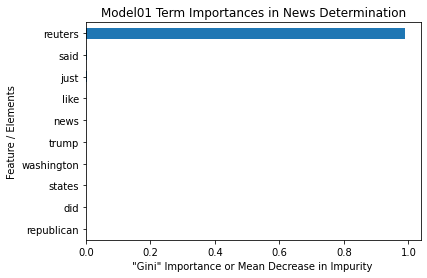

In [114]:
import matplotlib.pyplot as plt
importances = model1.named_steps['predictor'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('Model01 Term Importances in News Determination');

## MODEL 2 - min: 0.25   |  max: 0.5

In [105]:
# second model - pasting our TFIDF params below
# tfidf02 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)

model2 = Pipeline([
    #('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model2.fit(X_train2, y_train2); 

print(model2.score(X_train2, y_train2))

      Iter       Train Loss   Remaining Time 
         1           1.3357            3.75s
         2           1.2940            3.72s
         3           1.2593            3.71s
         4           1.2279            3.66s
         5           1.2010            3.62s
         6           1.1767            3.59s
         7           1.1558            3.55s
         8           1.1379            3.52s
         9           1.1206            3.47s
        10           1.1057            3.44s
        20           0.9999            3.06s
        30           0.9411            2.67s
        40           0.9045            2.29s
        50           0.8750            1.91s
        60           0.8516            1.52s
        70           0.8329            1.14s
        80           0.8190            0.76s
        90           0.8091            0.38s
       100           0.7999            0.00s
0.8238006230529595


In [109]:
print('model2 val: ', model2.score(X_val2, y_val2))
print('model2 test: ', model2.score(X_test2, y_test2))

model2 val:  0.8109657320872274
model2 test:  0.8204672897196261


## Feature Plot / Graphs 02:

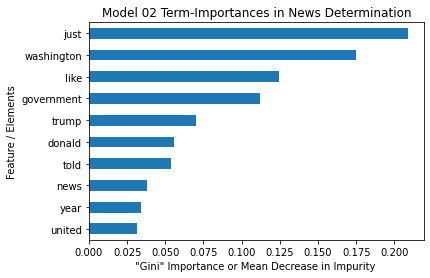

In [113]:
importances = model2.named_steps['predictor'].feature_importances_
features = X_train2.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('Model 02 Term-Importances in News Determination');

## Model 03 : min 0.05  |  max 0.5

In [121]:
# 3rd model, vectorizer params below :tfid03
# tfidf03 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.05 , max_df= 0.5)
model3 = Pipeline([
    #('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model3.fit(X_train3, y_train3); 

print(model3.score(X_train3, y_train3))

      Iter       Train Loss   Remaining Time 
         1           1.3256           12.74s
         2           1.2717           12.56s
         3           1.2277           12.42s
         4           1.1892           12.26s
         5           1.1519           12.11s
         6           1.1208           12.00s
         7           1.0933           11.87s
         8           1.0639           11.76s
         9           1.0395           11.63s
        10           1.0162           11.50s
        20           0.8358           10.20s
        30           0.7219            8.89s
        40           0.6470            7.61s
        50           0.5930            6.33s
        60           0.5491            5.05s
        70           0.5145            3.79s
        80           0.4860            2.52s
        90           0.4619            1.26s
       100           0.4416            0.00s
0.9325856697819315


In [122]:
print('model 03 val: ', model3.score(X_val3, y_val3))
print('model 03 test: ', model3.score(X_test3, y_test3))

model 03 val:  0.9214953271028037
model 03 test:  0.9201869158878505


## feature / plot / graphs 03: 

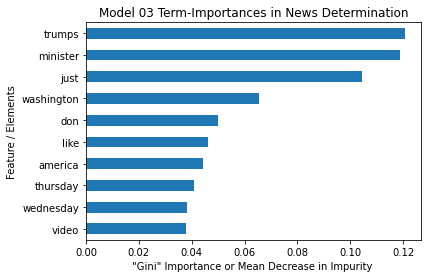

In [123]:
# third feature graph
importances = model3.named_steps['predictor'].feature_importances_
features = X_train3.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('Model 03 Term-Importances in News Determination');

## Model 04 -  min 0.01  |  max 0.1  - this should be really interesting...

In [136]:
# 4th model
# tfidf04 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.01 , max_df= 0.1)

model4 = Pipeline([
    #('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model4.fit(X_train4, y_train4); 

print(model4.score(X_train4, y_train4))

      Iter       Train Loss   Remaining Time 
         1           1.3468            6.62s
         2           1.3145            6.65s
         3           1.2876            6.58s
         4           1.2629            6.54s
         5           1.2409            6.46s
         6           1.2222            6.41s
         7           1.2045            6.35s
         8           1.1896            6.29s
         9           1.1750            6.22s
        10           1.1615            6.15s
        20           1.0565            5.45s
        30           0.9864            4.75s
        40           0.9328            4.05s
        50           0.8927            3.37s
        60           0.8597            2.69s
        70           0.8317            2.02s
        80           0.8083            1.35s
        90           0.7882            0.67s
       100           0.7708            0.00s
0.8554101765316718


In [137]:
print('model 04 val: ', model4.score(X_val4, y_val4))
print('model 04 test: ', model4.score(X_test4, y_test4))

model 04 val:  0.8346417445482867
model 04 test:  0.8406542056074766


## feature plot / graphs 04 :

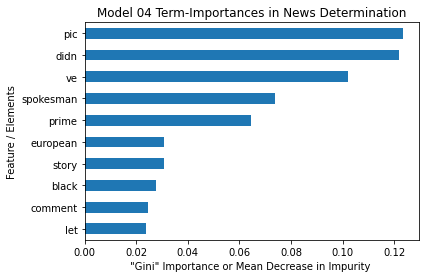

In [138]:
# fourth feature graph
importances = model4.named_steps['predictor'].feature_importances_
features = X_train4.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('Model 04 Term-Importances in News Determination');

In [142]:
# # whoa, so that's kind of fascinating... let's get those columns again just so we can see... 

# print(X_train4.columns)
# print(X_train3.columns)

In [ ]:
# one can look and see which terms are most strongly associated with each

# https://stackoverflow.com/questions/62496544/how-to-know-the-words-associated-with-a-specific-class-in-nlp-model

## some of these results are confusing, and I admit to being a bit dissapointed that the whole while we could simply check for the presence of the word "Reuters" but that doesn't really reflect real world modeling - like, what if there were no articles from Reuters in our observations? That alone would certainly not qualify fake news. In any case, we must move on. 

# Ok, so just to summarize for myself, with the exlcusion of Reuters "breaking" the need to vectorize text at all, our model seems to do much better when there is a higher range of term occurences included in the parameters... now to move on to more visualizations and clean up my draft for the writeup...

In [90]:
# from pdpbox.pdp import pdp_isolate, pdp_plot

# feature = 'date'

# # Build your `pdp_isolate`

# isolate = pdp_isolate(
#     model=model1,
#     dataset=X_test, #<-- Always use with VALIDATION or TEST data
#     model_features=X_test.columns,
#     feature=feature
# )

# # Build your plot
# pdp_plot(isolate, feature_name=feature);

In [ ]:
# # Josh Carslisle's Take on it all... 

# import xgboost as xgb
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# # Lets simplify : df_joined DF (80/20) split

# train = df_joined.loc[:34240,:]
# test = df_joined.loc[8560:,:]

# # For testing 

# y = train['Fake']
# X = train['text']

# # Instantiate vectorizer object
# vect = TfidfVectorizer(stop_words='english')
# clf = xgb.XGBClassifier() #estimator
# clf2 = GradientBoostingClassifier(random_state=42)

# # Define the Pipeline
# pipe = Pipeline([('vect', vect), ('clf', clf)])

# # super basic parameter list for tuning
# parameters = {
#     'vect__max_features': [500, 1000],
#     'clf__n_estimators':[75, 125]}
# # create the gridsearch
# grid_search = GridSearchCV(pipe, parameters, cv= 3, n_jobs=4, scoring='accuracy', verbose=1)
# grid_search.fit(X, y) # fit the model

# # results
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# # lets see how it does agaisnt the test
# pred = grid_search.predict(test['text'])